# Nonlinear Directional Coherence



In [1]:
import identFunctions as ident
import GFRFfunctions as GFRF
import numpy as np
import matplotlib.pyplot as plt
from sympy.plotting import plot3d, plot
import sympy as sym
from scipy.signal import filtfilt, butter, correlate
import scipy
%matplotlib notebook

All of those signals were estimated by computing the Nonlinear Output Frequency Response Function (NOFRF) (Billings, 2013) of the NARMAX identified systems. The systems were identified with the FROLS method (Billings, 2013).

## Example 1

\begin{align}
   u(i) =& 0.5u(i-1) - 0.3u(i-2) + 0.1y(i-2) + 0.4y(i-1)y(i-2) + eu(i-1)\\
   y(i) =& 0.3y(i-1) - y(i-2) - 0.1u(i-2) + ey(i-1)
\end{align}

In [ ]:
def system(u, Fs, noiseSTD=0.0, eu=0, ey=0):
    N = len(u)
    t = np.arange(0, N/Fs, 1/Fs)
#    y = np.sin(2*np.pi*4.52*t).reshape(-1,1)
    y = 0*np.random.randn(len(u), 1)
    
    for i in range(2, len(u)):
        u[i] = 0.5*u[i-1] - 0.3*u[i-2] + 0.1*y[i-2] + 0.4*y[i-1]*y[i-2] + eu[i-1]
        y[i] = 0.3*y[i-1] - y[i-2] - 0.1*u[i-2] + ey[i-1]

    u = u + noiseSTD*np.random.randn(N, 1)
    y = y + noiseSTD*np.random.randn(N, 1)
    
    return t, u, y

In [ ]:
Fs = 20.0
N = 100000

u = 0*np.random.randn(N, 1)
eu = 0.2*np.random.randn(N, 1)
ey = 0.2*np.random.randn(N, 1)

#ey = filtfilt(b, a, ey, axis = 0)
#eu = filtfilt(b, a, eu, axis = 0)

t, u, y = system(u, Fs, noiseSTD=0, eu=eu, ey=ey)

In [ ]:
plt.figure()
plt.plot(t, u)
plt.title('u')
plt.show()

In [ ]:
plt.figure()
plt.plot(t, y)
plt.title('y')
plt.show()

### Signals FFT

In [ ]:
fmin = 0
fmax = Fs/2
fres = 0.01
#%%
print('signals FFTs')
Y, f = GFRF.computeSignalFFT(ident.reshapeyvector(y, L=1), Fs, fres)
U, f = GFRF.computeSignalFFT(ident.reshapeyvector(u, L=1), Fs, fres)
EU, f = GFRF.computeSignalFFT(ident.reshapeyvector(eu, L=1), Fs, fres)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(U)))
plt.title('U')
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Y)))
plt.title('Y')
plt.show()

### System identification

In [ ]:
maxLagu = 2
maxLagy = 2
order = 2
u.shape

#### $u \rightarrow y$

In [ ]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u', 
                                         ystring='y', nstring='n', delay=1, degree=order, 
                                         L=20, constantTerm=True, pho = 0.005, supress=False, 
                                         elsMethod='RLS')

In [ ]:
%matplotlib notebook
ident.validation(u, n_uy, Duy, ustring='u', ystring='y')

#### $y \rightarrow u$

In [ ]:
beta_yu, n_yu, Dyu = ident.identifyModel(y, u, maxLagy, maxLagu, ustring='y',
                                         ystring='u', nstring='m', delay=1,
                                         degree=2, L=20, constantTerm=True,
                                         pho=0.01, supress=True)

In [ ]:
 ident.validation(y, n_yu, Dyu, ustring='y', ystring='u')

### Generalised Frequency Responses

#### $u \rightarrow y$

In [ ]:
Hnuy = GFRF.computeSystemGFRF(Duy, Fs, beta_uy, order, ustring='u', ystring='y')
Hnuy[1]

In [ ]:
Hnuy[2]

#### $y \rightarrow u$

In [ ]:
Hnyu = GFRF.computeSystemGFRF(Dyu, Fs, beta_yu, order, ustring='y', ystring='u')
Hnyu[1]

In [ ]:
Hnyu[2]

### Transfer of Power between the signals

\begin{equation}
    I_{U\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{y_l^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|U_{u_l^-,u_n^-}\right|^2}{\left|U_{u_l^-,u_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{U\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|U_{u_l^-,u_n^-} \right|^2}{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}


where $Y_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $y$ caused by the past of the signals $u$ and $y$, $U_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $u$ caused by the past of the signals $u$ and $y$, $Y_{y_l^-,y_n^-}$ is the intrinsic part of $y$ caused by the past of the signals $y$ and the error model $e_y$ and $U_{u_l^-,u_n^-}$ is the intrinsic part of $u$ caused by the past of the signals $u$ and the error model $e_u$. 

### Coherence 1 (Normalized Power Transfer)

\begin{equation}
    NC_{U\rightarrow Y} = \frac{I_{U \rightarrow Y}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

\begin{equation}
    NC_{Y\rightarrow U} = \frac{I_{Y \rightarrow U}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

In [ ]:
f_inputMin = 0
f_inputMax = Fs/2
maxDegree = 2
NPDCuy, NPDCyu, f, NPDCuyn, NPDCyun, NPDCuyLinear, NPDCyuLinear, NPDCuynLinear, NPDCyunLinear = GFRF.NPDC(u, y, Fs, fres, beta_uy, beta_yu, Duy, Dyu,
                                                                                                          Hnuy, Hnyu, f_inputMin, f_inputMax, maxOrder=maxDegree, 
                                                                                                          L=50, ustring='u', ystring='y')
    
        

In [ ]:
plt.figure()
# plt.plot(f, np.abs(NPDCuyn))
plt.plot(f, np.abs(NPDCuy))
# plt.plot(f, np.abs(np.mean(NPDCuyn, axis=1)), linewidth=6)
plt.ylim(0, 1)
plt.title('NPDC u->y')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyun))
plt.plot(f, np.abs(NPDCyu))
plt.ylim(0, 1)
plt.title('NPDC y->u')
plt.show()



                                                                                         
plt.figure()
# plt.plot(f, np.abs(NPDCuynLinear))
plt.plot(f, np.abs(NPDCuyLinear))
plt.ylim(0, 1)
plt.title('NPDC u->y Linear')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyunLinear))
plt.plot(f, np.abs(NPDCyuLinear))
plt.ylim(0, 1)
plt.title('NPDC y->u Linear')
plt.show()

## Example 2

\begin{align}
   u(i) =& 0.5u(i-1) - 0.3u(i-2) + 0.1y(i-2) + 0.4y(i-1)y(i-2) + eu(i-1)\\
   y(i) =& \sin\left(2\pi4.2\frac{i}{F_s}\right) + ey(i-1)
\end{align}

with $F_s=20$ Hz.

In [2]:
def system2(u, Fs, noiseSTD=0.0, eu=0, ey=0):
    N = len(u)
    t = np.arange(0, N/Fs, 1/Fs)
#     y = np.sin(2*np.pi*4.52*t).reshape(-1,1)
    y = 0*np.random.randn(len(u), 1)
    
    for i in range(2, len(u)):
        u[i] = 0.5*u[i-1] - 0.3*u[i-2] + 0.1*y[i-2] + 0.4*y[i-1]*y[i-2] + eu[i-1]
        y[i] = 5*np.sin(2*np.pi*4.5*t[i]) + ey[i-1]

    u = u + noiseSTD*np.random.randn(N, 1)
    y = y + noiseSTD*np.random.randn(N, 1)
    
    return t, u, y

In [3]:
Fs = 20.0
N = 100000

u = 0*np.random.randn(N, 1)
eu = 0.2*np.random.randn(N, 1)
ey = 0.1*np.random.randn(N, 1)

#ey = filtfilt(b, a, ey, axis = 0)
#eu = filtfilt(b, a, eu, axis = 0)

t, u, y = system2(u, Fs, noiseSTD=0, eu=eu, ey=ey)

<IPython.core.display.Javascript object>


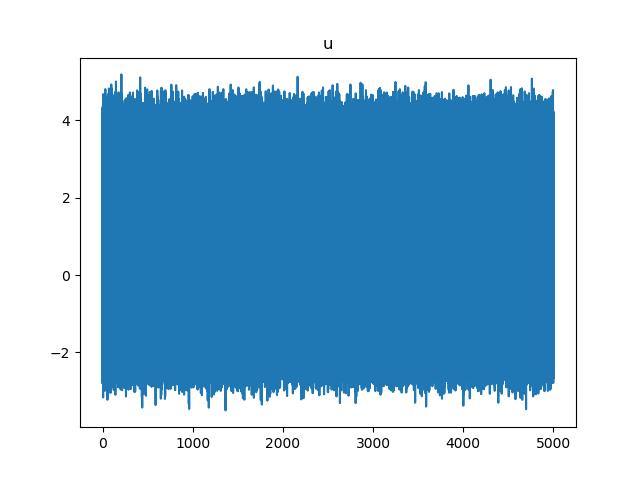

In [4]:
plt.figure()
plt.plot(t, u)
plt.title('u')
plt.show()

<IPython.core.display.Javascript object>


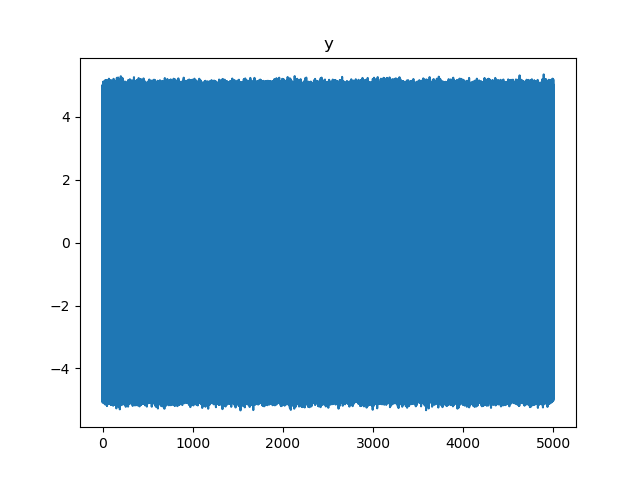

In [5]:
plt.figure()
plt.plot(t, y)
plt.title('y')
plt.show()

### Signals FFT

signals FFTs


<IPython.core.display.Javascript object>


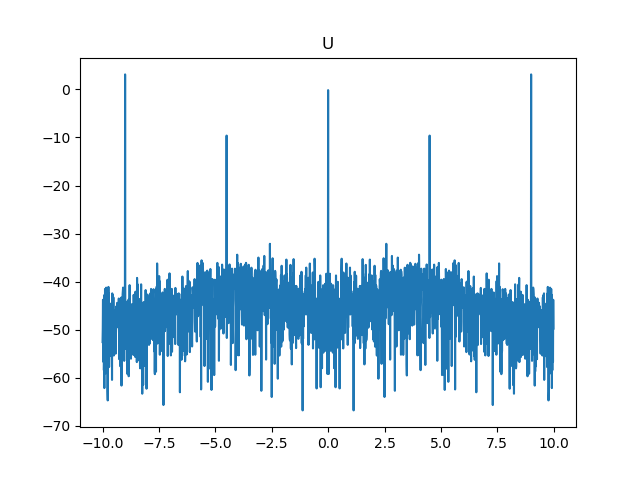

<IPython.core.display.Javascript object>


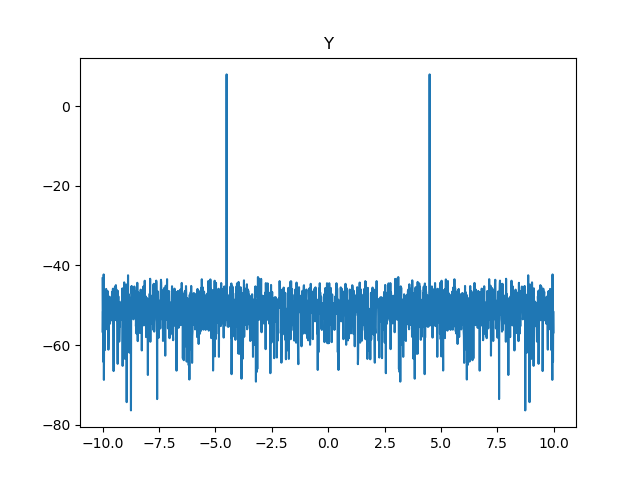

In [6]:
fmin = 0
fmax = Fs/2
fres = 0.01
#%%
print('signals FFTs')
Y, f = GFRF.computeSignalFFT(ident.reshapeyvector(y, L=1), Fs, fres)
U, f = GFRF.computeSignalFFT(ident.reshapeyvector(u, L=1), Fs, fres)
EU, f = GFRF.computeSignalFFT(ident.reshapeyvector(eu, L=1), Fs, fres)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(U)))
plt.title('U')
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Y)))
plt.title('Y')
plt.show()

### System identification

In [7]:
maxLagu = 5
maxLagy = 5
order = 2


#### $u \rightarrow y$

In [8]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u',
                                         ystring='y', nstring='n', delay=1,
                                         degree=order, L=20, constantTerm=True,
                                         pho = 0.0001, elsMethod='RLS', supress=False, 
                                         mfrolsEngine='python', elsEngine='python')

Mounting matrix of features for the MFROLS method
Executing MFROLS method
term number 0
ERR 0.9030712254753432
term number 1
ERR 0.09553743201880663
term number 2
ERR 0.00019381715118587544
term number 3
ERR 4.9536721330830205e-05
y(i-2) -0.43554415392452706
y(i-5) 0.28833009611150645
y(i-4) 0.37603415091651915
y(i-3) -0.17032876054623297
Initiating ELS method
ELS iteration - 0
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
y(i-2) -0.43155223415314825
y(i-3) -0.1693724852741562
y(i-4) 0.37933268244373164
y(i-5) 0.2905347177435706
ELS iteration - 1
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
y(i-2) -0.04825729600043235
y(i-3) -0.45935835209392717
y(i-4) 0.8160980060690852
y(i-5) 0.1206668817082005
n(i-1) 0.03001133394331407
n(i-2) -0.16703078849667333
n(i-3) 0.3514597768426617
n(i-4) -0.5621001274757123
n(i-5) -0.07698875526523459
ELS iteration - 2
Mounting matrix of features wit

In [9]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u',
                                         ystring='y', nstring='n', delay=1,
                                         degree=order, L=20, constantTerm=True,
                                         pho = 0.0001, supress=False, elsMethod='RLS',
                                         mfrolsEngine='fortran')

Mounting matrix of features for the MFROLS method
Executing MFROLS method
y(i-2) -0.4355441539254955
y(i-5) 0.28833009611119664
y(i-4) 0.37603415091564757
y(i-3) -0.1703287605462401
Initiating ELS method
ELS iteration - 0
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
y(i-2) -0.43155223415314825
y(i-3) -0.1693724852741562
y(i-4) 0.37933268244373164
y(i-5) 0.2905347177435706
ELS iteration - 1
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
y(i-2) -0.04825729600043235
y(i-3) -0.45935835209392717
y(i-4) 0.8160980060690852
y(i-5) 0.1206668817082005
n(i-1) 0.03001133394331407
n(i-2) -0.16703078849667333
n(i-3) 0.3514597768426617
n(i-4) -0.5621001274757123
n(i-5) -0.07698875526523459
ELS iteration - 2
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
y(i-2) -0.13718447929439573
y(i-3) -0.18513013910924583
y(i-4) 0.6500861896466106
y(i-5) 0

In [10]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u',
                                         ystring='y', nstring='n', delay=1,
                                         degree=order, L=20, constantTerm=True,
                                         pho = 0.0001, supress=False, elsMethod='RLS', 
                                         mfrolsEngine='fortran', elsEngine='fortran')

Mounting matrix of features for the MFROLS method
Executing MFROLS method
y(i-2) -0.4355441539254955
y(i-5) 0.28833009611119664
y(i-4) 0.37603415091564757
y(i-3) -0.1703287605462401
Initiating ELS method
ELS iteration - 0
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
y(i-2) -0.4315522341563309
y(i-3) -0.1693724852712994
y(i-4) 0.37933268244014545
y(i-5) 0.29053471774554424
ELS iteration - 1
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
y(i-2) -0.04825729599475352
y(i-3) -0.45935835208567855
y(i-4) 0.8160980060712258
y(i-5) 0.12066688171813968
n(i-1) 0.03001133394337849
n(i-2) -0.1670307885054112
n(i-3) 0.3514597768329411
n(i-4) -0.5621001274732892
n(i-5) -0.07698875526796237
ELS iteration - 2
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
y(i-2) -0.13718447926197683
y(i-3) -0.1851301390017462
y(i-4) 0.6500861896425522
y(i-5) 0.

#### $y \rightarrow u$

In [11]:
beta_yu, n_yu, Dyu = ident.identifyModel(y, u, maxLagy, maxLagu, ustring='y',
                                         ystring='u', nstring='m', delay=1,
                                         degree=2, L=20, constantTerm=True, elsMethod='RLS', 
                                         pho=0.0001, supress=False, 
                                         mfrolsEngine='fortran', elsEngine='fortran')

Mounting matrix of features for the MFROLS method
Executing MFROLS method
y(i-1)y(i-2) 0.40009365806375535
y(i-2)y(i-3) 0.0003807773792295219
y(i-5) 0.00014725944871175033
y(i-2) 0.10002698459995212
u(i-3) -0.0007290697821731194
u(i-2) -0.30015166007343025
u(i-1) 0.49970716421112593
y(i-1)u(i-5) 0.00011497432610731409
Initiating ELS method
ELS iteration - 0
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
y(i-2) 0.10003859910960532
y(i-5) 0.00014169460351322395
u(i-1) 0.49960766519464017
u(i-2) -0.3000890829237043
u(i-3) -0.0007446664140817361
y(i-1)y(i-2) 0.4000942967827147
y(i-1)u(i-5) 0.00011436359141927755
y(i-2)y(i-3) 0.0004221986376081274
ELS iteration - 1
Mounting matrix of features with noise
Executing RLS method
Computing residue of the identification
y(i-2) 0.10087688864473396
y(i-5) 0.0029408102282691036
u(i-1) 0.5244764812625559
u(i-2) -0.3128916263125546
u(i-3) 0.006577361330733062
y(i-1)y(i-2) 0.40005530922299265
y(i-1)u(

Executing RLS method
Computing residue of the identification
y(i-2) 0.1008956306917149
y(i-5) 0.0029943343939169585
u(i-1) 0.5250253021263841
u(i-2) -0.3131435193193272
u(i-3) 0.0067755317058192785
y(i-1)y(i-2) 0.40004688083869266
y(i-1)u(i-5) 0.00013896206309543094
y(i-2)y(i-3) -0.009845956485999268
m(i-1) -0.06118458406450131
m(i-2) -0.06179094567629609
m(i-3) -0.08222986330230267
m(i-4) -0.01210459462283022
m(i-5) -0.020222895924138274
y(i-1)m(i-1) -0.02341548107733417
y(i-1)m(i-2) 0.021934721544607412
y(i-1)m(i-3) 0.047874778334250474
y(i-1)m(i-4) -0.020032514546328227
y(i-1)m(i-5) 0.032444789651828135
y(i-2)m(i-1) -0.0025896960016078426
y(i-2)m(i-2) -0.0006143540246238869
y(i-2)m(i-3) -0.007078406169889529
y(i-2)m(i-4) 0.01268700380012634
y(i-2)m(i-5) 0.05423472213967468
y(i-3)m(i-1) 0.050105899606832115
y(i-3)m(i-2) 0.025402436955664187
y(i-3)m(i-3) 0.04225144921315296
y(i-3)m(i-4) -0.010424866041467263
y(i-3)m(i-5) 0.015995202601169576
y(i-4)m(i-1) -0.028022242442533898
y(i-4)m(

Executing RLS method
Computing residue of the identification
y(i-2) 0.10089569698356256
y(i-5) 0.0029945477756331148
u(i-1) 0.5250272306847185
u(i-2) -0.31314448436450354
u(i-3) 0.006776111208675996
y(i-1)y(i-2) 0.40004688056665466
y(i-1)u(i-5) 0.00013896211389721841
y(i-2)y(i-3) -0.009846728356510463
m(i-1) -0.06118655732732146
m(i-2) -0.061790682055941855
m(i-3) -0.08222986578718562
m(i-4) -0.012104630320874794
m(i-5) -0.020222808818061613
y(i-1)m(i-1) -0.023415411294301643
y(i-1)m(i-2) 0.021934643566622388
y(i-1)m(i-3) 0.04787483391605894
y(i-1)m(i-4) -0.020032370634939293
y(i-1)m(i-5) 0.032444808013314
y(i-2)m(i-1) -0.002589654189617782
y(i-2)m(i-2) -0.0006142208047632174
y(i-2)m(i-3) -0.00707849671060694
y(i-2)m(i-4) 0.012686899750601622
y(i-2)m(i-5) 0.05423473466967662
y(i-3)m(i-1) 0.050106008445810445
y(i-3)m(i-2) 0.025402575784705648
y(i-3)m(i-3) 0.04225158478025182
y(i-3)m(i-4) -0.010424924102067691
y(i-3)m(i-5) 0.01599513588448593
y(i-4)m(i-1) -0.028022165419308877
y(i-4)m(i-

In [12]:
_, n_uy, maxLag_uy = ident.osaWithStruct(u, y, beta_uy, Duy, 2, 
                                         ustring='u', ystring='y')
n_uy

array([[ 3.72589344],
       [ 1.78636025],
       [-0.18366152],
       ...,
       [ 0.03764609],
       [ 0.09030962],
       [-0.09523129]])

In [13]:
_, n_yu, maxLag_yu = ident.osaWithStruct(y, u, beta_yu, Dyu, 2, 
                                         ustring='y', ystring='u')
n_yu

array([[ 0.04501454],
       [-0.08950312],
       [-0.15485745],
       ...,
       [-0.31732522],
       [-0.04920025],
       [ 0.12695106]])

### Generalised Frequency Responses

#### $u \rightarrow y$

In [14]:
Hnuy = GFRF.computeSystemGFRF(Duy, Fs, beta_uy, order, ustring='u', ystring='y')
Hnuy[1]

0

In [15]:
Hnuy[2]

0

#### $y \rightarrow u$

In [16]:
Hnyu = GFRF.computeSystemGFRF(Dyu, Fs, beta_yu, order, ustring='y', ystring='u')
Hnyu[1]

(0.00299454775913636*exp(-0.5*I*pi*f1) + 0.100895696979544*exp(-0.2*I*pi*f1))/(1 - 0.00677611116358578*exp(-0.3*I*pi*f1) + 0.313144484288281*exp(-0.2*I*pi*f1) - 0.525027230540041*exp(-0.1*I*pi*f1))

In [17]:
Hnyu[2]

(0.000138962113919595*(0.00299454775913636*exp(-0.5*I*pi*f1) + 0.100895696979544*exp(-0.2*I*pi*f1))*exp(-0.5*I*pi*f1)*exp(-0.1*I*pi*f2)/(1 - 0.00677611116358578*exp(-0.3*I*pi*f1) + 0.313144484288281*exp(-0.2*I*pi*f1) - 0.525027230540041*exp(-0.1*I*pi*f1)) - 0.00984672829616101*exp(-I*(0.2*pi*f1 + 0.3*pi*f2)) + 0.400046880568082*exp(-I*(0.1*pi*f1 + 0.2*pi*f2)))/(1 - 0.525027230540041*exp(-I*(0.1*pi*f1 + 0.1*pi*f2)) + 0.313144484288281*exp(-2*I*(0.1*pi*f1 + 0.1*pi*f2)) - 0.00677611116358578*exp(-3*I*(0.1*pi*f1 + 0.1*pi*f2)))

<IPython.core.display.Javascript object>


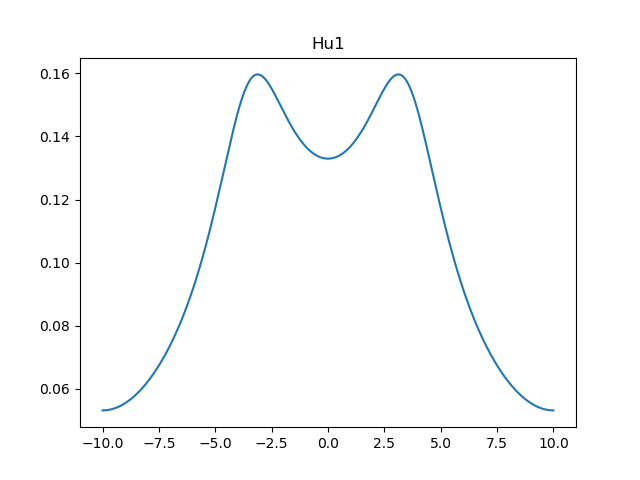

<IPython.core.display.Javascript object>


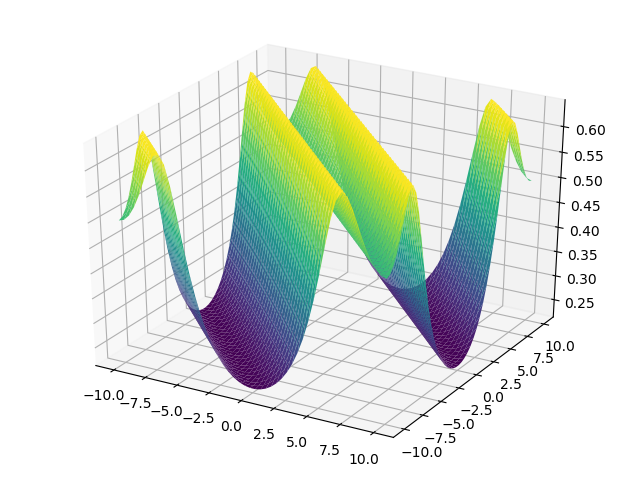

In [18]:
f1, f2 = sym.symbols('f1 f2')
Hu = sym.lambdify(f1, Hnyu[1], 'numpy')

fV = np.linspace(-Fs/2, Fs/2, 100000)


plt.figure()
plt.plot(fV, np.abs(Hu(fV)))
plt.title('Hu1')
plt.show()


plot3d(sym.Abs(Hnyu[2]), (f1,-Fs/2, Fs/2), (f2,-Fs/2, Fs/2))


### Transfer of Power between the signals

### Coherence (Normalized Power Transfer)

\begin{equation}
    NC_{U\rightarrow Y} = \frac{I_{U \rightarrow Y}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

\begin{equation}
    NC_{Y\rightarrow U} = \frac{I_{Y \rightarrow U}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

In [19]:
f_inputMin = 0
f_inputMax = Fs/2
maxDegree = 2
Iuy, Iyu, f, Iuyn, Iyun, IuyLinear, IyuLinear, IuynLinear, IyunLinear, IuyConf, IyuConf = GFRF.NPDC(u, y, Fs, fres, beta_uy, beta_yu, Duy, Dyu,
                                                                                                    Hnuy, Hnyu, f_inputMin, f_inputMax, maxOrder=maxDegree, 
                                                                                                    L=50, ustring='u', ystring='y', mfrolsEngine='python',
                                                                                                    elsEngine='fortran')



y(i-2) -0.178978785300018
y(i-3) 0.09758472424496313
y(i-4) -0.018171920013366805
y(i-5) -0.02451922138931524




y(i-2) -0.0004164378028678331
y(i-5) 0.0017244165458377512
u(i-1) 0.06271102714119033
u(i-2) 0.5066239475780304
u(i-3) 0.07801391532960028
y(i-1)y(i-2) -0.0008805473173900468
y(i-1)u(i-5) 0.00013436562184243866
y(i-2)y(i-3) -8.276442172511222e-06




In [ ]:
Iuy, Iyu, f, Iuyn, Iyun, IuyLinear, IyuLinear, IuynLinear, IyunLinear, IuyConf, IyuConf = GFRF.NPDC(u, y, Fs, fres, beta_uy, beta_yu, Duy, Dyu,
                                                                                                    Hnuy, Hnyu, f_inputMin, f_inputMax, maxOrder=maxDegree, 
                                                                                                    L=50, ustring='u', ystring='y', mfrolsEngine='fortran',
                                                                                                    elsEngine='fortran')



y(i-2) 0.022836152286884293
y(i-3) -0.0365014775302551
y(i-4) -0.07668697014219958
y(i-5) 0.10464240307377494




y(i-2) -0.0006885830066603532
y(i-5) 0.00023310745719624826
u(i-1) 0.1379856610679086
u(i-2) 0.4134280284203631
u(i-3) 0.09531533842373845
y(i-1)y(i-2) 0.00026550312048847363
y(i-1)u(i-5) -0.0009742117648344062
y(i-2)y(i-3) 0.00010202957701693199




In [ ]:
plt.figure()
# plt.plot(f, np.abs(NPDCuyn))
plt.plot(f, Iuy)
plt.plot(f, np.ones_like(f)*IuyConf, '--', linewidth=5)
# plt.plot(f, np.abs(np.mean(NPDCuyn, axis=1)), linewidth=6)
# plt.ylim(0, )
plt.title('NPDC u->y')
plt.show()

plt.figure()
# plt.plot(f, NPDCyun)
plt.plot(f, Iyu, linewidth=5)
plt.plot(f, np.ones_like(f)*IyuConf, '--', linewidth=5)
# plt.ylim(0, )
plt.title('NPDC y->u')
plt.show()
                                                                                         
plt.figure()
# plt.plot(f, np.abs(NPDCuynLinear))
plt.plot(f, IuyLinear)
plt.plot(f, np.ones_like(f)*IuyConf, '--', linewidth=5)
plt.ylim(0, )
plt.title('NPDC u->y Linear')
plt.show()

plt.figure()
# plt.plot(f, np.abs(NPDCyunLinear))
plt.plot(f, IyuLinear)
plt.plot(f, np.ones_like(f)*IyuConf, '--', linewidth=5)
plt.ylim(0, )
plt.title('NPDC y->u Linear')
plt.show()

## Example 3

\begin{align}
    y(i) = & \sin(2\pi2i) + \sin(2\pi3i) +e_y(i-1)\\
    u(i) = & 0.5u(i-1) - 0.3u(i-2) +0.1y(i-2) + 0.1u(i-2)^2 +0.4y(i-1)y(i-2) + e_y(i-1)
\end{align}

In [ ]:
def system3(u, Fs, noiseSTD=0.0, eu=0, ey=0):
    N = len(u)
    t = np.arange(0, N/Fs, 1/Fs)
#     y = np.sin(2*np.pi*4.52*t).reshape(-1,1)
    y = 0*np.random.randn(len(u), 1)
    
    for i in range(2, len(u)):
        y[i] = np.sin(2*np.pi*2*t[i]) + np.sin(2*np.pi*3*t[i]) + ey[i-1]
        u[i] = 0.5*u[i-1] - 0.3*u[i-2] + 0.1*y[i-2] + 0.1*u[i-2]**2 + 0.4*y[i-1]*y[i-2] + eu[i-1]

    u = u + noiseSTD*np.random.randn(N, 1)
    y = y + noiseSTD*np.random.randn(N, 1)
    
    return t, u, y

In [ ]:
Fs = 20.0
N = 600

u = 0*np.random.randn(N, 1)
eu = 0.05*np.random.randn(N, 1)
ey = 0.02*np.random.randn(N, 1)

#ey = filtfilt(b, a, ey, axis = 0)
#eu = filtfilt(b, a, eu, axis = 0)

t, u, y = system3(u, Fs, noiseSTD=0, eu=eu, ey=ey)

In [ ]:
plt.figure()
plt.plot(t, u)
plt.title('u')
plt.show()

In [ ]:
plt.figure()
plt.plot(t, y)
plt.title('y')
plt.show()

### Signals FFT

In [ ]:
fmin = 0
fmax = Fs/2
fres = 0.01
#%%
print('signals FFTs')
Y, f = GFRF.computeSignalFFT(ident.reshapeyvector(y, L=1), Fs, fres)
U, f = GFRF.computeSignalFFT(ident.reshapeyvector(u, L=1), Fs, fres)
EU, f = GFRF.computeSignalFFT(ident.reshapeyvector(eu, L=1), Fs, fres)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(U)))
plt.title('U')
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Y)))
plt.title('Y')
plt.show()

### System identification

In [ ]:
maxLagu = 2
maxLagy = 2
order = 2


#### $u \rightarrow y$

In [ ]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u',
                                         ystring='y', nstring='n', delay=1,
                                         degree=order, L=1, constantTerm=True,
                                         pho = 0.001, supress=False, elsMethod='RLS')

#### $y \rightarrow u$

In [ ]:
beta_yu, n_yu, Dyu = ident.identifyModel(y, u, maxLagy, maxLagu, ustring='y',
                                         ystring='u', nstring='m', delay=1,
                                         degree=2, L=1, constantTerm=True,
                                         pho=0.0001, supress=False, elsMethod='RLS')

### Generalised Frequency Responses

#### $u \rightarrow y$

In [ ]:
Hnuy = GFRF.computeSystemGFRF(Duy, Fs, beta_uy, order, ustring='u', ystring='y')
Hnuy[1]

In [ ]:
Hnuy[2]

#### $y \rightarrow u$

In [ ]:
Hnyu = GFRF.computeSystemGFRF(Dyu, Fs, beta_yu, order, ustring='y', ystring='u')
Hnyu[1]

In [ ]:
Hnyu[2]

### Transfer of Power between the signals

\begin{equation}
    I_{U\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{y_l^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|U_{u_l^-,u_n^-}\right|^2}{\left|U_{u_l^-,u_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{U\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|U_{u_l^-,u_n^-} \right|^2}{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}


where $Y_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $y$ caused by the past of the signals $u$ and $y$, $U_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $u$ caused by the past of the signals $u$ and $y$, $Y_{y_l^-,y_n^-}$ is the intrinsic part of $y$ caused by the past of the signals $y$ and the error model $e_y$ and $U_{u_l^-,u_n^-}$ is the intrinsic part of $u$ caused by the past of the signals $u$ and the error model $e_u$. 

### Coherence 1 (Normalized Power Transfer)

\begin{equation}
    NC_{U\rightarrow Y} = \frac{I_{U \rightarrow Y}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

\begin{equation}
    NC_{Y\rightarrow U} = \frac{I_{Y \rightarrow U}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

In [ ]:
f_inputMin = 0
f_inputMax = Fs/2
maxDegree = 2
NPDCuy, NPDCyu, f, NPDCuyn, NPDCyun, NPDCuyLinear, NPDCyuLinear, NPDCuynLinear, NPDCyunLinear = GFRF.NPDC(u, y, Fs, fres, beta_uy, beta_yu, Duy, Dyu,
                                                                                                          Hnuy, Hnyu, f_inputMin, f_inputMax, maxOrder=maxDegree, 
                                                                                                          L=50, ustring='u', ystring='y')
    

In [ ]:
plt.figure()
# plt.plot(f, np.abs(NPDCuyn))
plt.plot(f, np.abs(NPDCuy))
# plt.plot(f, np.abs(np.mean(NPDCuyn, axis=1)), linewidth=6)
plt.ylim(0, 1)
plt.title('NPDC u->y')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyun))
plt.plot(f, np.abs(NPDCyu))
plt.ylim(0, 1)
plt.title('NPDC y->u')
plt.show()



                                                                                         
plt.figure()
# plt.plot(f, np.abs(NPDCuynLinear))
plt.plot(f, np.abs(NPDCuyLinear))
plt.ylim(0, 1)
plt.title('NPDC u->y Linear')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyunLinear))
plt.plot(f, np.abs(NPDCyuLinear))
plt.ylim(0, 1)
plt.title('NPDC y->u Linear')
plt.show()

## Example 4

\begin{align}
   u(i) = & 0.5u(i-1) - 0.3u(i-2) +0.1y(i-2) + 0.1u(i-2)^2 +0.4y(i-1)y(i-2) + e_u(i-1)\\
   y(i) =& 0.3y(i-1) - y(i-2) - 0.1u(i-2) + ey(i-1)\\   
\end{align}

In [ ]:
def system4(u, Fs, noiseSTD=0.0, eu=0, ey=0):
    N = len(u)
    t = np.arange(0, N/Fs, 1/Fs)
#    y = np.sin(2*np.pi*4.52*t).reshape(-1,1)
    y = 0*np.random.randn(len(u), 1)
    
    for i in range(2, len(u)):
        u[i] = 0.5*u[i-1] - 0.3*u[i-2] + 0.1*y[i-2] + 0.1*u[i-2]**2 + 0.4*y[i-1]*y[i-2] + eu[i-1]
        y[i] = 0.3*y[i-1] - y[i-2] - 0.1*u[i-2] + ey[i-1]

    u = u + noiseSTD*np.random.randn(N, 1)
    y = y + noiseSTD*np.random.randn(N, 1)
    
    return t, u, y

In [ ]:
Fs = 20.0
N = 100000

u = 0*np.random.randn(N, 1)
eu = 0.1*np.random.randn(N, 1)
ey = 0.1*np.random.randn(N, 1)

#ey = filtfilt(b, a, ey, axis = 0)
#eu = filtfilt(b, a, eu, axis = 0)

t, u, y = system4(u, Fs, noiseSTD=0, eu=eu, ey=ey)

In [ ]:
plt.figure()
plt.plot(t, u)
plt.title('u')
plt.show()

In [ ]:
plt.figure()
plt.plot(t, y)
plt.title('y')
plt.show()

### Signals FFT

In [ ]:
fmin = 0
fmax = Fs/2
fres = 0.01
#%%
print('signals FFTs')
Y, f = GFRF.computeSignalFFT(ident.reshapeyvector(y, L=1), Fs, fres)
U, f = GFRF.computeSignalFFT(ident.reshapeyvector(u, L=1), Fs, fres)
EU, f = GFRF.computeSignalFFT(ident.reshapeyvector(eu, L=1), Fs, fres)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(U)))
plt.title('U')
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Y)))
plt.title('Y')
plt.show()

### System identification

In [ ]:
maxLagu = 2
maxLagy = 2
order = 2


#### $u \rightarrow y$

In [ ]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u',
                                         ystring='y', nstring='n', delay=1,
                                         degree=order, L=20, constantTerm=True,
                                         pho = 0.005, supress=False)

#### $y \rightarrow u$

In [ ]:
beta_yu, n_yu, Dyu = ident.identifyModel(y, u, maxLagy, maxLagu, ustring='y',
                                         ystring='u', nstring='m', delay=1,
                                         degree=2, L=20, constantTerm=True,
                                         pho=0.0001, supress=False)

### Generalised Frequency Responses

#### $u \rightarrow y$

In [ ]:
Hnuy = GFRF.computeSystemGFRF(Duy, Fs, beta_uy, order, ustring='u', ystring='y')
Hnuy[1]

In [ ]:
Hnuy[2]

#### $y \rightarrow u$

In [ ]:
Hnyu = GFRF.computeSystemGFRF(Dyu, Fs, beta_yu, order, ustring='y', ystring='u')
Hnyu[1]

In [ ]:
Hnyu[2]

### Transfer of Power between the signals

\begin{equation}
    I_{U\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{y_l^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|U_{u_l^-,u_n^-}\right|^2}{\left|U_{u_l^-,u_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{U\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|U_{u_l^-,u_n^-} \right|^2}{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}


where $Y_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $y$ caused by the past of the signals $u$ and $y$, $U_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $u$ caused by the past of the signals $u$ and $y$, $Y_{y_l^-,y_n^-}$ is the intrinsic part of $y$ caused by the past of the signals $y$ and the error model $e_y$ and $U_{u_l^-,u_n^-}$ is the intrinsic part of $u$ caused by the past of the signals $u$ and the error model $e_u$. 

### Coherence (Normalized Power Transfer)

\begin{equation}
    NC_{U\rightarrow Y} = \frac{I_{U \rightarrow Y}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

\begin{equation}
    NC_{Y\rightarrow U} = \frac{I_{Y \rightarrow U}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

In [ ]:
L = 50
NPDCuy, NPDCyu, f, NPDCuyn, NPDCyun, NPDCuyLinear, NPDCyuLinear, NPDCuynLinear, NPDCyunLinear = GFRF.NPDC(u, y, Fs, fres, beta_uy, beta_yu, Duy, Dyu,
                                                                                                          Hnuy, Hnyu, f_inputMin, f_inputMax, maxOrder=maxDegree, 
                                                                                                          N=L, ustring='u', ystring='y')
    


Th = 1 - (1-0.95)**(1/(L-1))

In [ ]:
plt.figure()
# plt.plot(f, np.abs(NPDCuyn))
plt.plot(f, np.abs(NPDCuy))
plt.plot(f, Th*np.ones_like(f), '--k')
# plt.plot(f, np.abs(np.mean(NPDCuyn, axis=1)), linewidth=6)
plt.ylim(0, 1)
plt.title('NPDC u->y')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyun))
plt.plot(f, np.abs(NPDCyu))
plt.plot(f, Th*np.ones_like(f), '--k')
plt.ylim(0, 1)
plt.title('NPDC y->u')
plt.show()



                                                                                         
plt.figure()
# plt.plot(f, np.abs(NPDCuynLinear))
plt.plot(f, np.abs(NPDCuyLinear))
plt.plot(f, Th*np.ones_like(f), '--k')
plt.ylim(0, 1)
plt.title('NPDC u->y Linear')
plt.show()


plt.figure()
# plt.plot(f, np.abs(NPDCyunLinear))
plt.plot(f, np.abs(NPDCyuLinear))
plt.plot(f, Th*np.ones_like(f), '--k')
plt.ylim(0, 1)
plt.title('NPDC y->u Linear')
plt.show()

## Example 5

\begin{align}
   u(i) = &  e_u(i-1)\\
   y(i) =& e_y(i-1)\\   
\end{align}

In [ ]:
def system5(u, Fs, noiseSTD=0.0, eu=0, ey=0):
    N = len(u)
    t = np.arange(0, N/Fs, 1/Fs)
#    y = np.sin(2*np.pi*4.52*t).reshape(-1,1)
    y = 0*np.random.randn(len(u), 1)
    
    for i in range(0, len(u)):
        u[i] = eu[i]
        y[i] = ey[i]

    u = u + noiseSTD*np.random.randn(N, 1)
    y = y + noiseSTD*np.random.randn(N, 1)
    
    return t, u, y

In [ ]:
Fs = 20.0
N = 100000

u = 0*np.random.randn(N, 1)
eu = 0.1*np.random.randn(N, 1)
ey = 0.1*np.random.randn(N, 1)

#ey = filtfilt(b, a, ey, axis = 0)
#eu = filtfilt(b, a, eu, axis = 0)

t, u, y = system5(u, Fs, noiseSTD=0, eu=eu, ey=ey)

In [ ]:
plt.figure()
plt.plot(t, u)
plt.title('u')
plt.show()

In [ ]:
plt.figure()
plt.plot(t, y)
plt.title('y')
plt.show()

### Signals FFT

In [ ]:
fmin = 0
fmax = Fs/2
fres = 0.01
#%%
print('signals FFTs')
Y, f = GFRF.computeSignalFFT(ident.reshapeyvector(y, L=1), Fs, fres)
U, f = GFRF.computeSignalFFT(ident.reshapeyvector(u, L=1), Fs, fres)
EU, f = GFRF.computeSignalFFT(ident.reshapeyvector(eu, L=1), Fs, fres)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(U)))
plt.title('U')
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Y)))
plt.title('Y')
plt.show()

### System identification

In [ ]:
maxLagu = 2
maxLagy = 2
order = 2


#### $u \rightarrow y$

In [ ]:
beta_uy, n_uy, Duy = ident.identifyModel(u, y, maxLagu, maxLagy, ustring='u',
                                         ystring='y', nstring='n', delay=1,
                                         degree=order, L=200, constantTerm=True,
                                         pho = 0.0001, supress=False)

#### $y \rightarrow u$

In [ ]:
beta_yu, n_yu, Dyu = ident.identifyModel(y, u, maxLagy, maxLagu, ustring='y',
                                         ystring='u', nstring='m', delay=1,
                                         degree=2, L=200, constantTerm=True,
                                         pho=0.0001, supress=False)

### Generalised Frequency Responses

#### $u \rightarrow y$

In [ ]:
Hnuy = GFRF.computeSystemGFRF(Duy, Fs, beta_uy, order, ustring='u', ystring='y')
Hnuy[1]

In [ ]:
Hnuy[2]

#### $y \rightarrow u$

In [ ]:
Hnyu = GFRF.computeSystemGFRF(Dyu, Fs, beta_yu, order, ustring='y', ystring='u')
Hnyu[1]

In [ ]:
Hnyu[2]

### Transfer of Power between the signals

\begin{equation}
    I_{U\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{y_l^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2 + \left|U_{u_l^-,u_n^-}\right|^2}{\left|U_{u_l^-,u_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{U\rightarrow U} = \ln\frac{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|U_{u_l^-,u_n^-} \right|^2}{\left|U_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}

\begin{equation}
    I_{Y\rightarrow Y} = \ln\frac{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-}  \right|^2 + \left|Y_{y_l^-,y_n^-} \right|^2}{\left|Y_{u_l^-,y_l^-,u_n^-,y_n^-} \right|^2}
\end{equation}


where $Y_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $y$ caused by the past of the signals $u$ and $y$, $U_{u_l^-,y_l^-,u_n^-,y_n^-}$ is the part of $u$ caused by the past of the signals $u$ and $y$, $Y_{y_l^-,y_n^-}$ is the intrinsic part of $y$ caused by the past of the signals $y$ and the error model $e_y$ and $U_{u_l^-,u_n^-}$ is the intrinsic part of $u$ caused by the past of the signals $u$ and the error model $e_u$. 

### Coherence 1 (Normalized Power Transfer)

\begin{equation}
    NC_{U\rightarrow Y} = \frac{I_{U \rightarrow Y}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

\begin{equation}
    NC_{Y\rightarrow U} = \frac{I_{Y \rightarrow U}}{\sqrt{I_{U \rightarrow Y}^2+I_{Y \rightarrow Y}^2+I_{U \rightarrow U}^2+I_{Y \rightarrow U}^2}}
\end{equation}

In [ ]:
NPDCuy, NPDCyu, f, NPDCuyn, NPDCyun, NPDCuyLinear, NPDCyuLinear, NPDCuynLinear, NPDCyunLinear = GFRF.NPDC(u, y, Fs, fres, beta_uy, beta_yu, Duy, Dyu,
                                                                                                          Hnuy, Hnyu, f_inputMin, f_inputMax, maxOrder=maxDegree, 
                                                                                                          N=50, ustring='u', ystring='y')
    

In [ ]:
plt.figure()
plt.plot(f, np.abs(NPDCuyn))
plt.plot(f, np.abs(NPDCuy))
# plt.plot(f, np.abs(np.mean(NPDCuyn, axis=1)), linewidth=6)
plt.ylim(0, 1)
plt.title('NPDC u->y')
plt.show()

plt.figure()
plt.plot(f, np.abs(NPDCyun))
plt.plot(f, np.abs(NPDCyu))
plt.ylim(0, 1)
plt.title('NPDC y->u')
plt.show()
                                                                                       
plt.figure()
# plt.plot(f, np.abs(NPDCuynLinear))
plt.plot(f, np.abs(NPDCuyLinear))
plt.ylim(0, 1)
plt.title('NPDC u->y Linear')
plt.show()

plt.figure()
plt.plot(f, np.abs(NPDCyunLinear))
plt.plot(f, np.abs(NPDCyuLinear))
plt.ylim(0, 1)
plt.title('NPDC y->u Linear')
plt.show()

In [ ]:
L = 1
Th = (np.log((np.abs(np.mean(Y)/L)**2)/(np.abs(1e-7)**2))/
      np.sqrt(2*np.log((np.abs(np.mean(Y)/L)**2)/(np.abs(1e-7)**2))**2 +
              + 2*np.log((np.abs(np.mean(Y)/L)**2)/(np.abs(np.mean(Y)/L+1e-7)**2))**2))

Th

In [ ]:
1/np.sqrt(2)